In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import re
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from sklearn.metrics import confusion_matrix ,accuracy_score,classification_report

In [44]:
df=pd.read_csv('train.csv')

In [45]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [46]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [47]:
df.shape

(20800, 5)

In [48]:
df=df.dropna()

In [50]:
## get the independent features
X=df.drop('label',axis=1)

In [51]:
y=df.label

In [52]:
## Check whether dataset is balanced or not
y.value_counts()

0    10361
1     7924
Name: label, dtype: int64

In [53]:
## vocabulary size
voc_size=5000

One Hot Representation

In [54]:
messages=X.copy()

In [57]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [58]:
messages.reset_index(inplace=True)

In [75]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [76]:
onehot_repr=[one_hot(words,voc_size) for words in corpus]

Embedding Representation

In [77]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)


Creating Model

In [86]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(200)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 40)            200000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 400)               385600    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 1)                 401       
                                                                 
Total params: 586001 (2.24 MB)
Trainable params: 586001 (2.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [87]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [88]:
## train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

Model Training

In [91]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",mode="min", patience=5,restore_best_weights=True)

In [92]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=32, callbacks=[earlystopping])

Epoch 1/30
383/383 [==============================] - 3s 9ms/step - loss: 6.6768e-07 - accuracy: 1.0000 - val_loss: 0.9812 - val_accuracy: 0.9079
Epoch 2/30
383/383 [==============================] - 3s 9ms/step - loss: 5.3800e-07 - accuracy: 1.0000 - val_loss: 0.9996 - val_accuracy: 0.9079
Epoch 3/30
383/383 [==============================] - 4s 10ms/step - loss: 4.4156e-07 - accuracy: 1.0000 - val_loss: 1.0142 - val_accuracy: 0.9082
Epoch 4/30
383/383 [==============================] - 3s 8ms/step - loss: 3.5501e-07 - accuracy: 1.0000 - val_loss: 1.0255 - val_accuracy: 0.9079
Epoch 5/30
383/383 [==============================] - 3s 9ms/step - loss: 2.8979e-07 - accuracy: 1.0000 - val_loss: 1.0402 - val_accuracy: 0.9079
Epoch 6/30
383/383 [==============================] - 4s 10ms/step - loss: 2.3905e-07 - accuracy: 1.0000 - val_loss: 1.0543 - val_accuracy: 0.9080


Performance metrics

In [93]:
y_pred=model.predict(X_test)

189/189 [==============================] - 1s 3ms/step


In [94]:
y_pred=np.where(y_pred>=0.5,1,0)

In [95]:
cf_matrix = confusion_matrix(y_test,y_pred)

In [96]:
print(accuracy_score(y_test,y_pred))

0.907870753935377


In [97]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3419
           1       0.89      0.90      0.89      2616

    accuracy                           0.91      6035
   macro avg       0.91      0.91      0.91      6035
weighted avg       0.91      0.91      0.91      6035



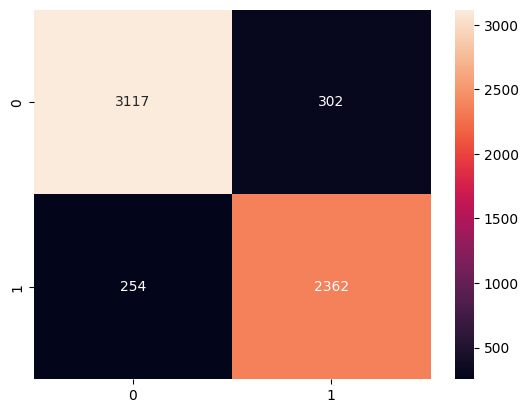

In [98]:
sns.heatmap(cf_matrix,annot =True,fmt='d')
plt.show()